In [1]:
from abc import ABC, abstractmethod
from collections import deque

%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

In [2]:
def show_map(graph_data, node_colors=None):
    G = nx.Graph(graph_data['graph_dict'])
    node_col = node_colors or graph_data['node_col']
    node_pos = graph_data['node_pos']
    node_label_pos = graph_data['node_label_pos']
    
    # set the size of the plot
    plt.figure(figsize=(18, 13))
    
    # draw the graph
    nx.draw(G, pos={k: node_pos[k] for k in G.nodes()},
            node_color=[node_col[node] for node in G.nodes()], linewidths=0.3, edgecolors='k')
    
    # draw labels
    node_label = nx.draw_networkx_labels(G, pos=node_label_pos, font_size=14)
    
    # adding white background behind the labels
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label.values()]
    
    plt.show()
    
    
def save_map(graph_data, i, node_colors=None):
    G = nx.Graph(graph_data['graph_dict'])
    node_col = node_colors or graph_data['node_col']
    node_pos = graph_data['node_pos']
    node_label_pos = graph_data['node_label_pos']
    
    # set the size of the plot
    plt.figure(figsize=(18, 13))
    
    # draw the graph
    nx.draw(G, pos={k: node_pos[k] for k in G.nodes()},
            node_color=[node_col[node] for node in G.nodes()], linewidths=0.3, edgecolors='k')
    
    # draw labels
    node_label = nx.draw_networkx_labels(G, pos=node_label_pos, font_size=14)
    
    # adding white background behind the labels
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label.values()]
    
    plt.savefig(f"C:/Users/imsub/Desktop/New folder/{i}.jpg")


In [3]:
def display_visual(graph_data, algorithm=None, problem=None):
    initial_node_colors = graph_data['node_col']
    
    def slider_callback(iteration):
        try:
            show_map(graph_data, node_colors=all_node_colors[iteration])
        except:
            pass
    
    def visualize_callback(visualize):
        if visualize :
            button.value = False
            
            global all_node_colors

            iterations, all_node_colors, node = algorithm(problem)
            solution = node.solution()
            all_node_colors.append(final_path_colors(all_node_colors[0], problem, solution))
            
            slider.max = len(all_node_colors) - 1

            for i in range(slider.max + 1):
                slider.value = i
    
    slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
    slider_visual = widgets.interactive(slider_callback, iteration=slider)
    display(slider_visual)
    
    button = widgets.ToggleButton(value=False)
    button_visual = widgets.interactive(visualize_callback, visualize=button)
    display(button_visual)
    
    
    
    
def final_path_colors(initial_node_colors, problem, solution):
    "Return a node_colors dict of the final path provided the problem and solution."
    # get initial node colors
    final_colors = dict(initial_node_colors)
    # color all the nodes in solution and starting node to green
    final_colors[problem.initial] = "green"
    for node in solution:
        final_colors[node] = "green"
    return final_colors
    

In [4]:
# data for the problem of travelling Romania
romania_map_graph = dict(
    Arad = ['Zerind', 'Sibiu', 'Timisoara'],
    Bucharest = ["Urziceni", "Pitesti", "Giurgiu", "Fagaras"],
    Craiova=["Drobeta", "Rimnicu", "Pitesti"],
    Drobeta=["Mehadia"],
    Eforie=["Hirsova"],
    Fagaras=["Sibiu"],
    Hirsova=["Urziceni"],
    Iasi=["Vaslui", "Neamt"],
    Lugoj=["Timisoara", "Mehadia"],
    Oradea=["Zerind", "Sibiu"],
    Pitesti=["Rimnicu"],
    Rimnicu=["Sibiu"],
    Urziceni=["Vaslui"]
)

In [5]:
class Problem(ABC):
    def __init__(self, initial, goal=None):
        self.initial = initial
        self.goal = goal
        
    @abstractmethod
    def actions(self, state):
        pass
    
    @abstractmethod
    def result(self, state, action):
        pass
    
    def goal_test(self, state):
        if isinstance(self.goal, list):
            return any(x is state for x in self.goal)
        else:
            return state == self.goal

In [6]:
class GraphProblem(Problem):
    def __init__(self, initial, goal, graph):
        super().__init__(initial, goal)
        self.graph = graph
        
    def actions(self, A):
        return list(self.graph.get(A))
    
    def result(self, state, action):
        return action

In [7]:
class Graph:
    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            # make the graph undirected
            self.make_undirected()
            
    def make_undirected(self):
        for parent in list(self.graph_dict.keys()):    # keys of the graph dict
            for child in self.graph_dict[parent]:      # each value of the value list
                
                # if the value is in the dict i.e., update the list of the existing parents
                if child in self.graph_dict:
                    # update the list if the parent is not in it.
                    if parent not in self.graph_dict[child]:
                        self.connect(child, parent)
                
                # if the child in not in the dict
                else:
                    self.connect(child, parent)
                
    def connect(self, A, B):
        self.graph_dict.setdefault(A, []).append(B)
        
    def get(self, a, b=None):
        links = self.graph_dict.setdefault(a, {})
        return links if b is None else links.get(b)
    
    def nodes(self):
        s1 = set([k for k in self.graph_dict])
        s2 = set([l for v in self.graph_dict.values() for l in v])
        nodes = s1.union(s2)
        return list(nodes)
    
    
def UndirectedGraph(graph_dict=None):
    return Graph(graph_dict=graph_dict, directed=False)

In [8]:
class Node:
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
    
    def __repr__(self):
        return f"<Node {self.state}>"
    
    def expand(self, problem):
        return [self.child_node(problem, action)
               for action in problem.actions(self.state)]
    
    def child_node(self, problem, action):
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action)
        return next_node
    
    def solution(self):
        return [node.action for node in self.path()[1:]]
    
    def path(self):
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return path_back[::-1]

In [9]:
a = romania_map_graph.copy()

a = UndirectedGraph(a)

a.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531)
)

print(a.locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


In [10]:
def bfs(problem):
    
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    node = Node(problem.initial)
    
    node_colors[node.state] = 'red'
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = 'green'
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return (iterations, all_node_colors, node)
    
    frontier = deque([node])
    
    node_colors[node.state] = 'orange'
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    
    while frontier:
        node = frontier.popleft()
        node_colors[node.state] = 'red'
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        explored.add(node.state)
        
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    node_colors[child.state] = 'green'
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    return (iterations, all_node_colors, child)
                frontier.append(child)
                
                node_colors[child.state] = 'orange'
                iterations += 1
                all_node_colors.append(dict(node_colors))
                
        node_colors[node.state] = 'gray'
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

In [17]:
all_node_colors = []

romania_problem = GraphProblem('Neamt', 'Zerind', a)

path = bfs(romania_problem)

In [18]:
node_colors = {node: 'white' for node in a.locations.keys()}
node_positions = a.locations
node_label_pos = {k: [v[0], v[1] - 10] for k, v in a.locations.items()}

data = dict(
    graph_dict = a.graph_dict,
    node_col = node_colors,
    node_pos = node_positions,
    node_label_pos = node_label_pos
)

display_visual(data, algorithm=bfs, problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

# Saving map in the local directory

C:\Users\imsub\AppData\Local\Temp\ipykernel_8076\3620706530.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 13))


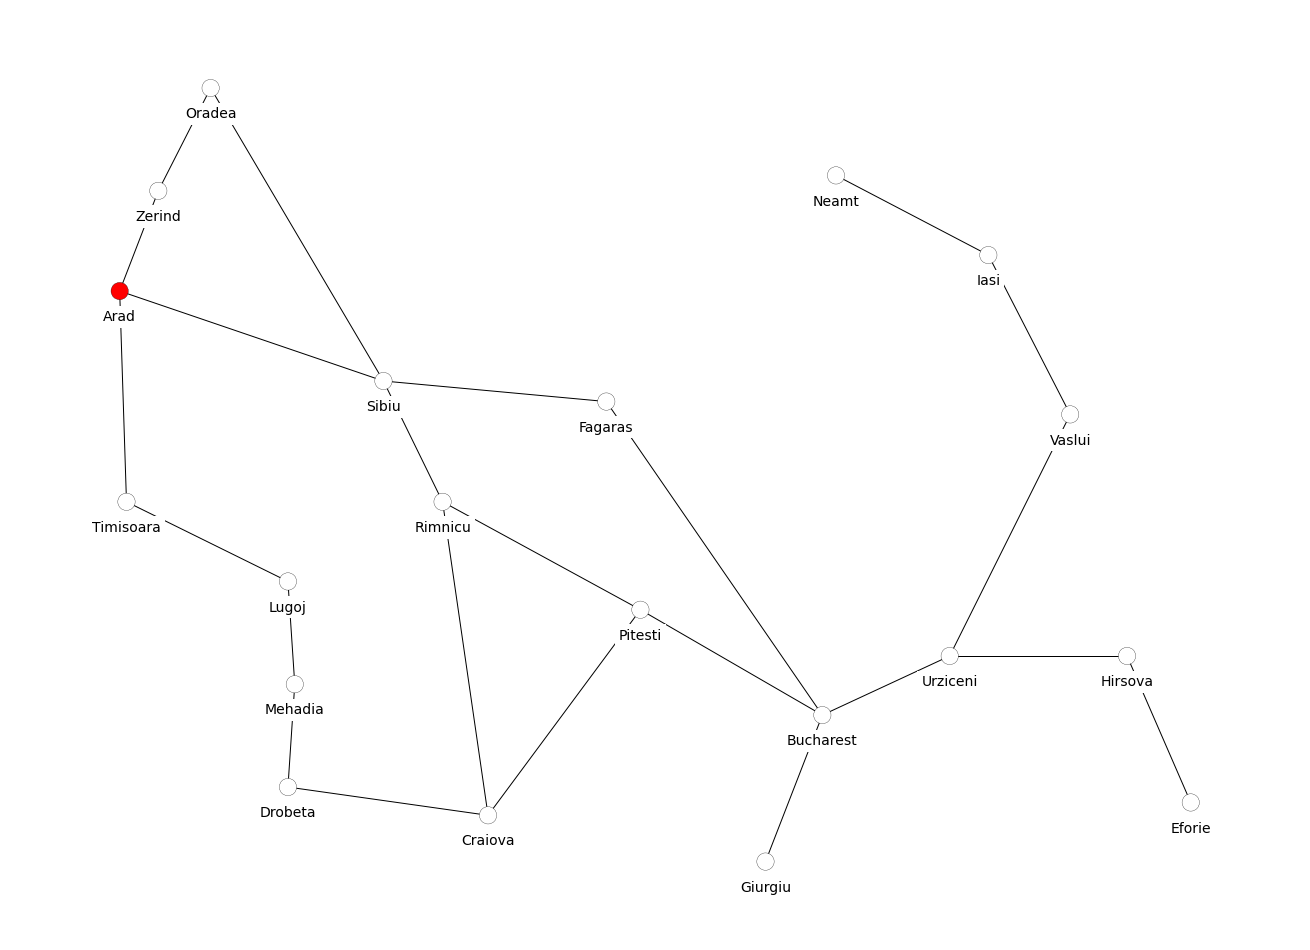

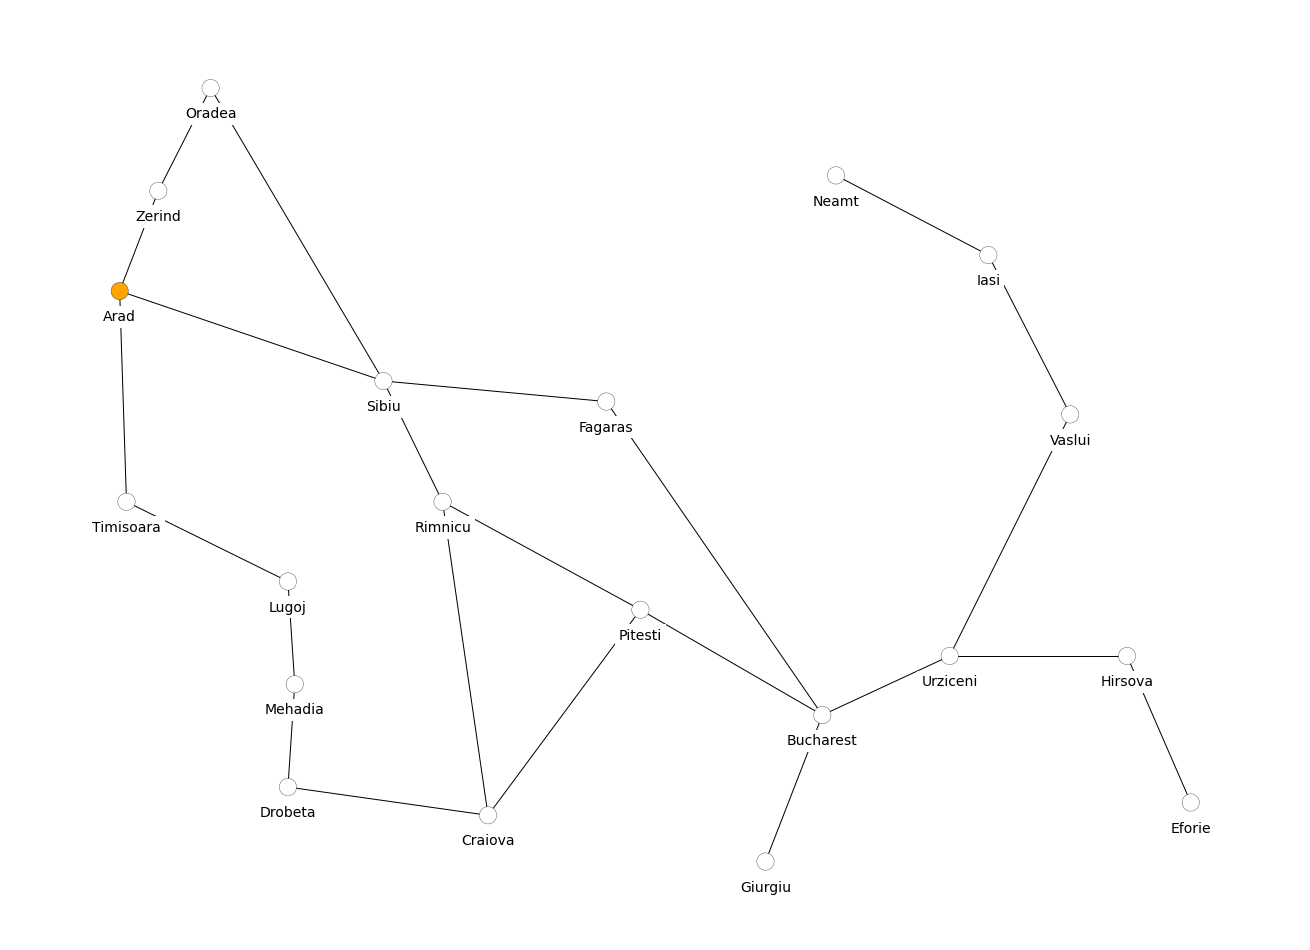

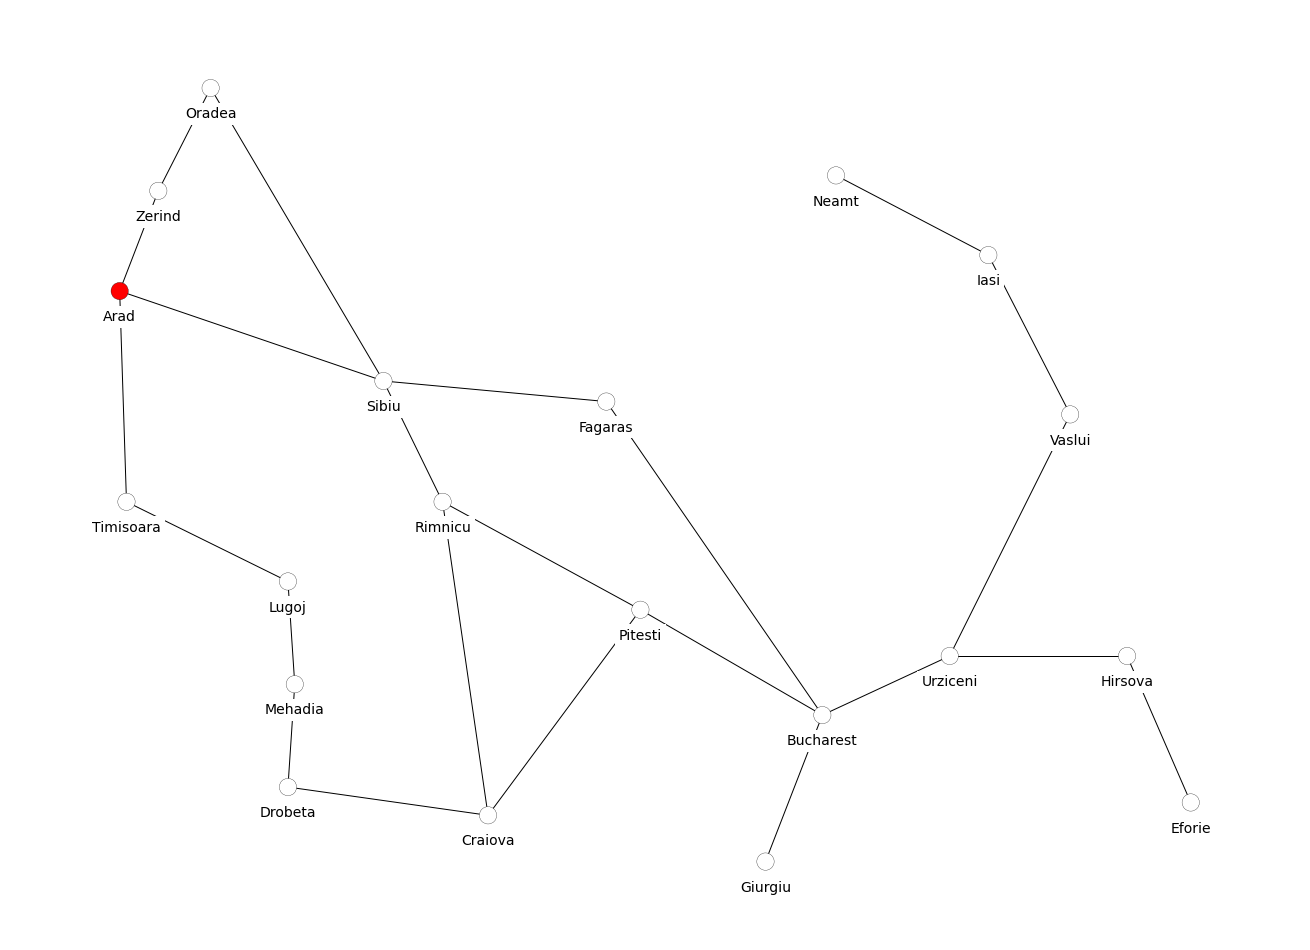

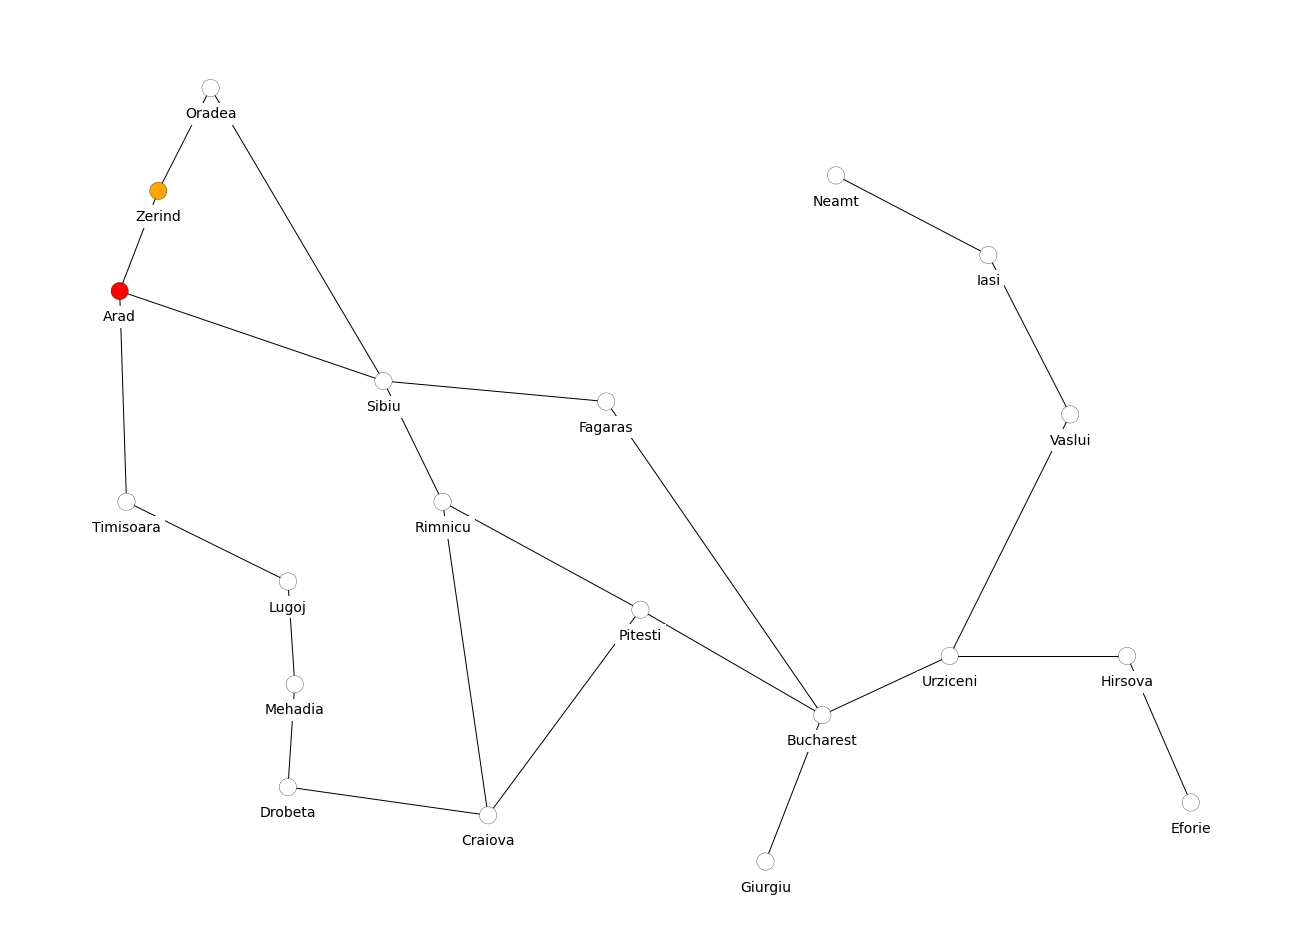

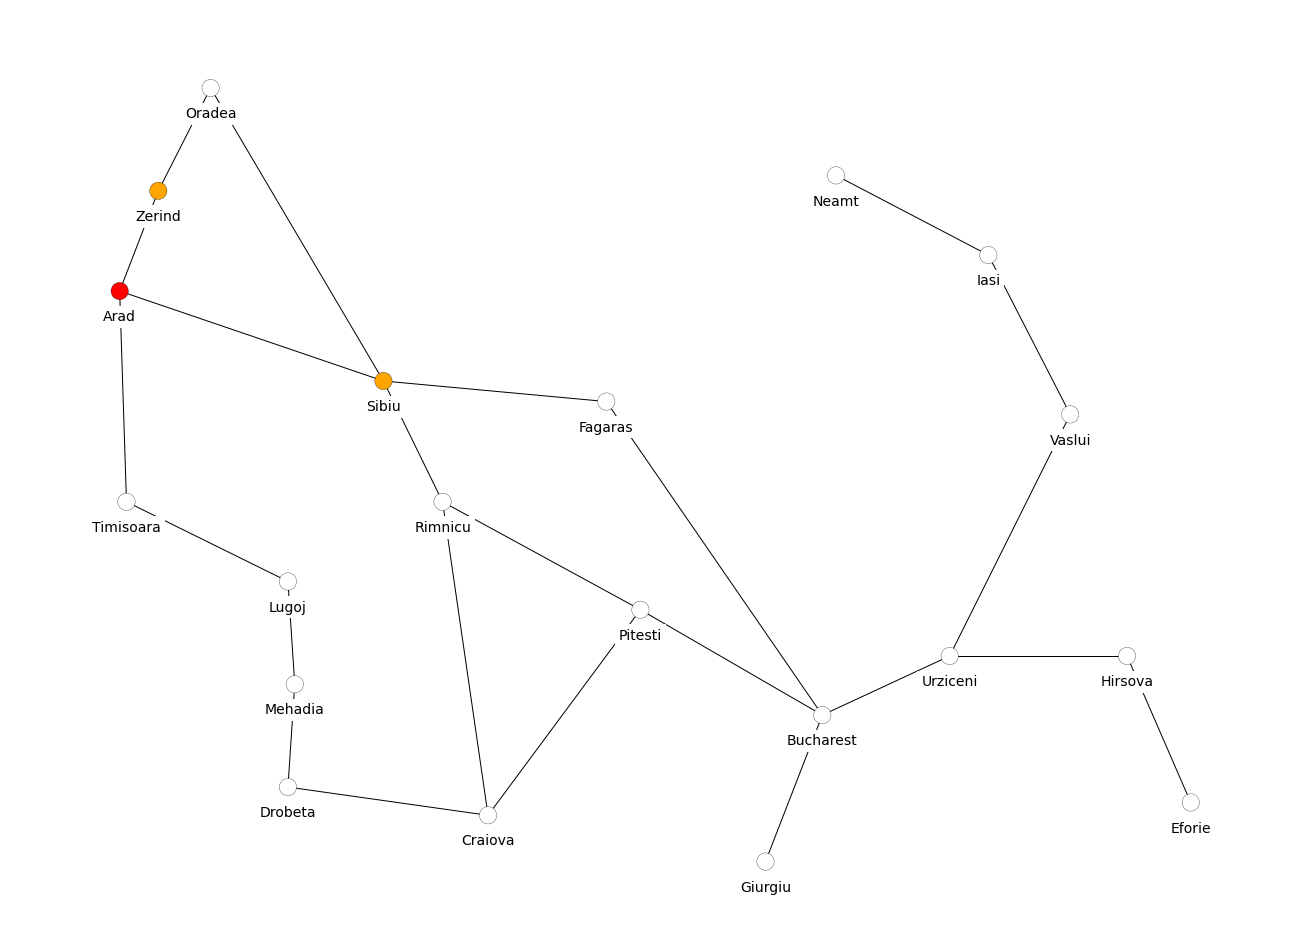

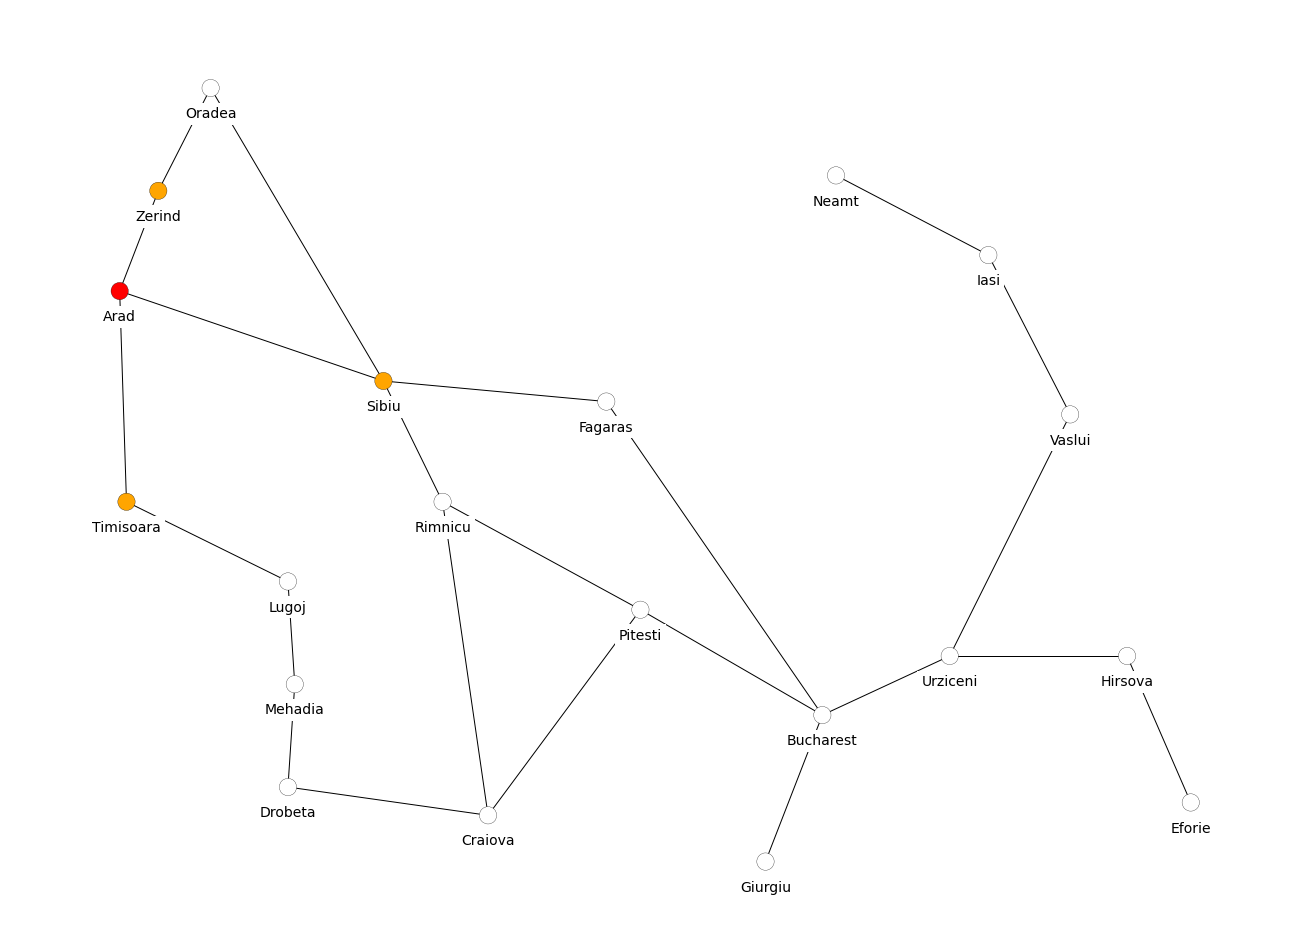

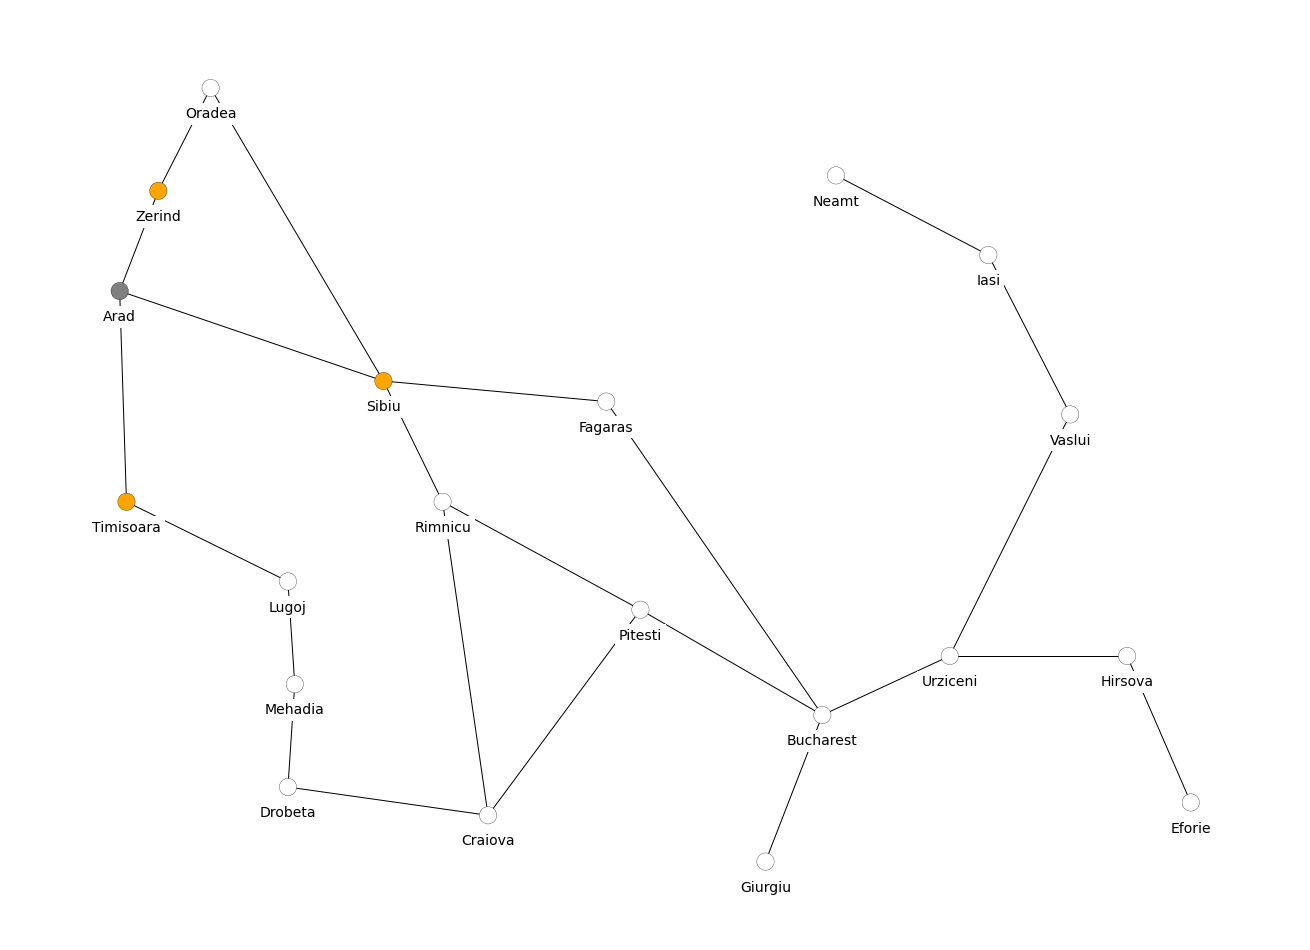

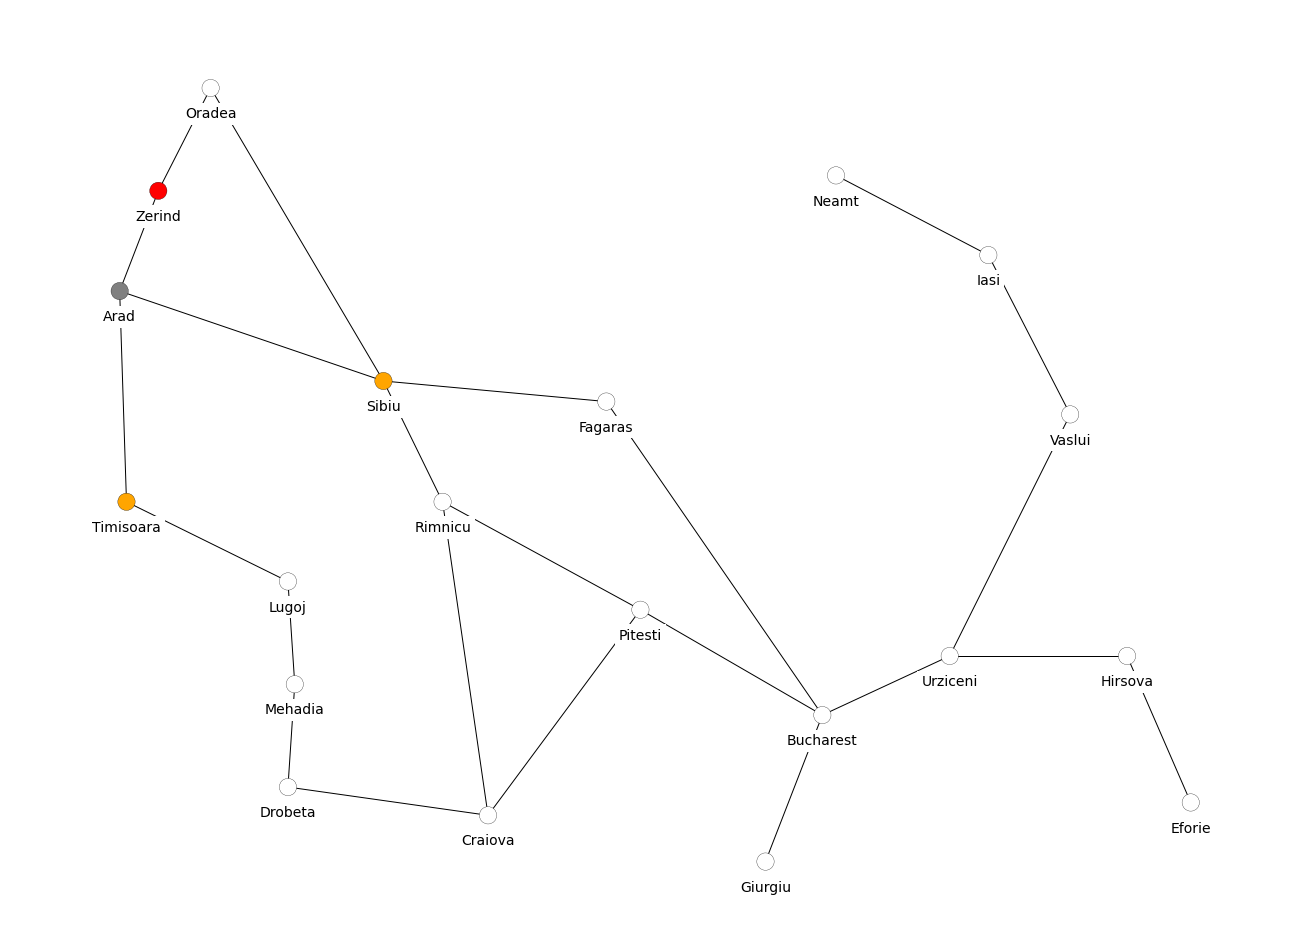

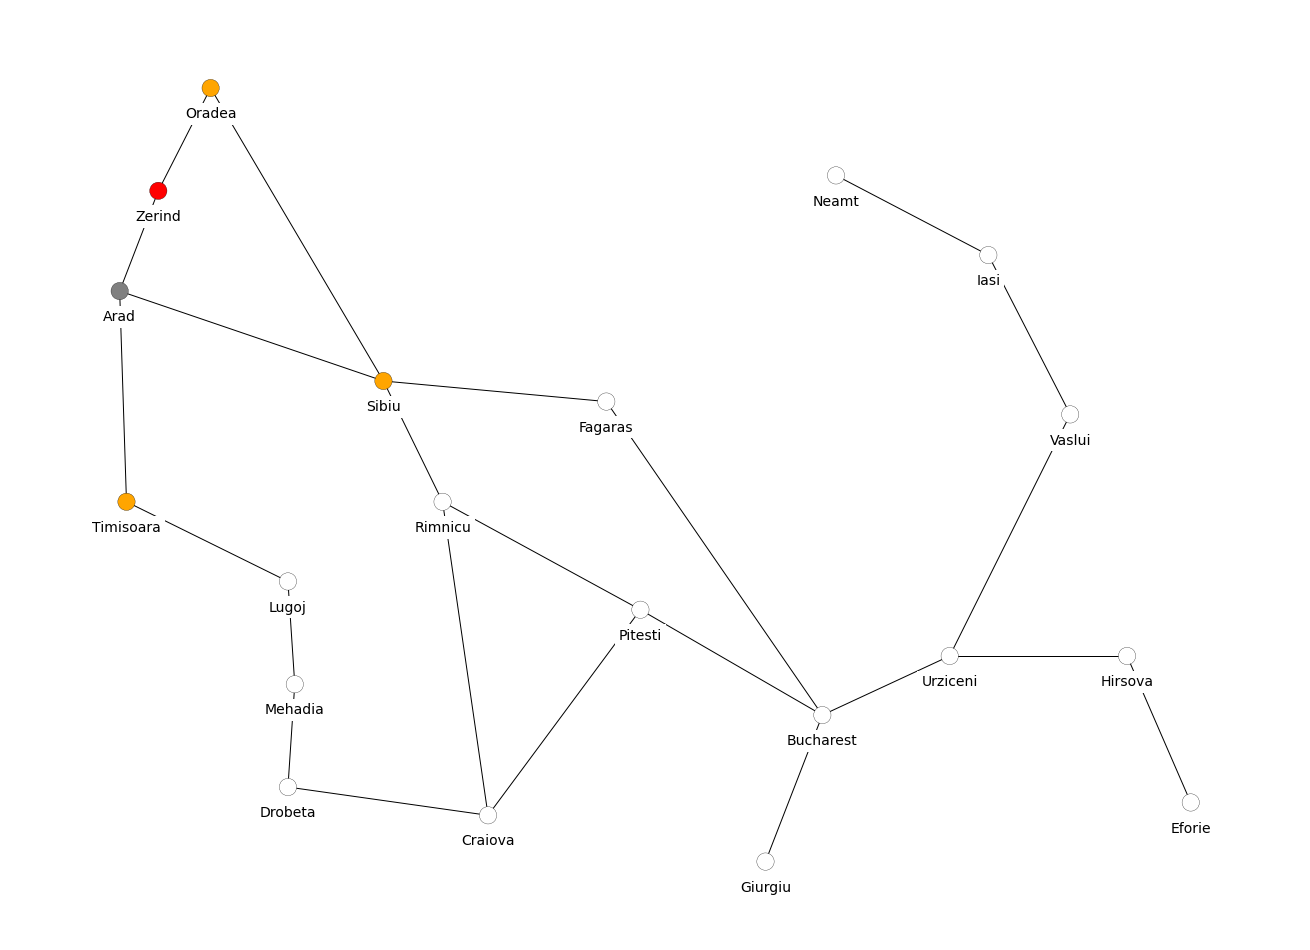

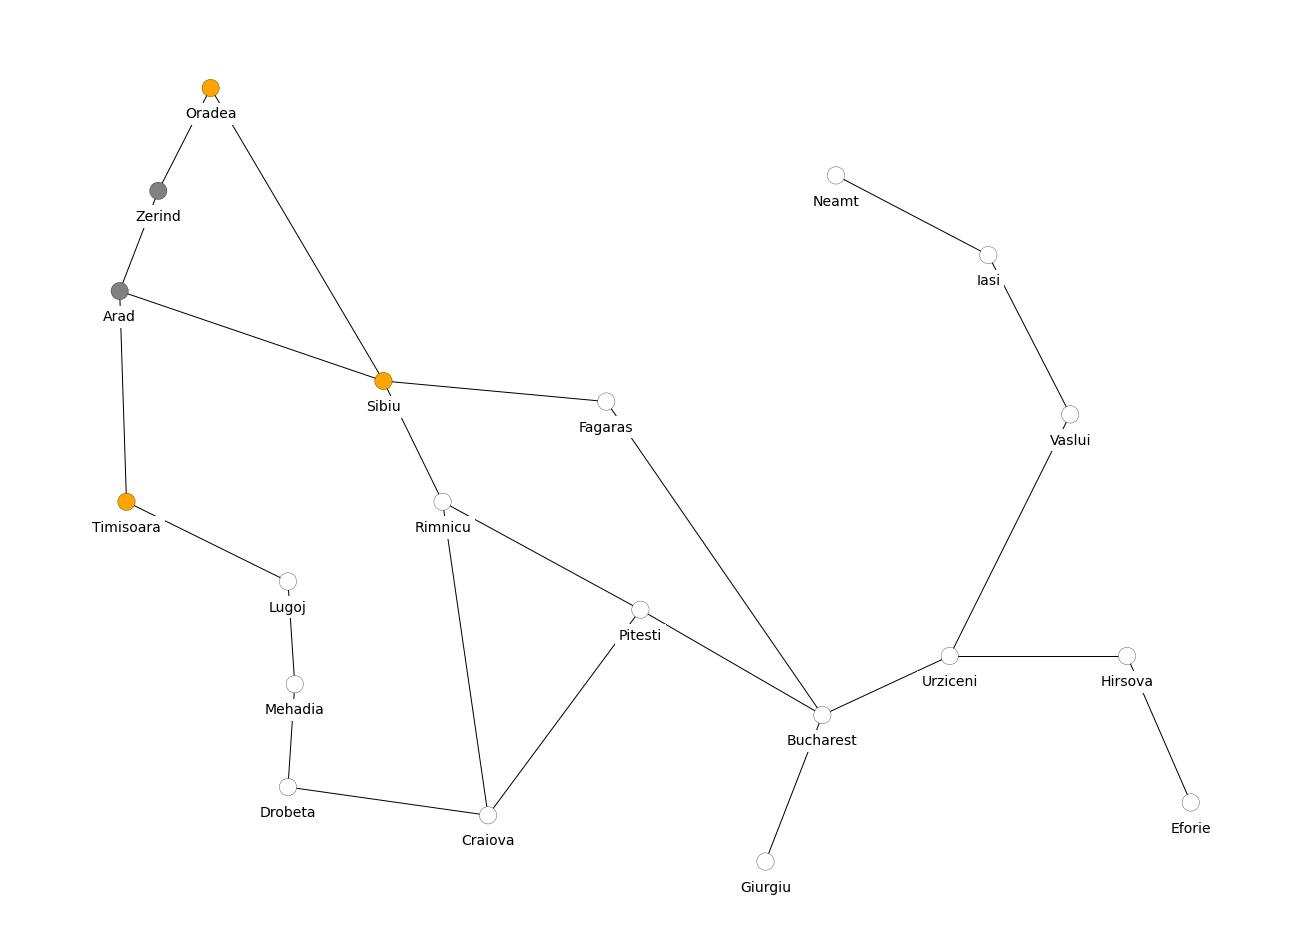

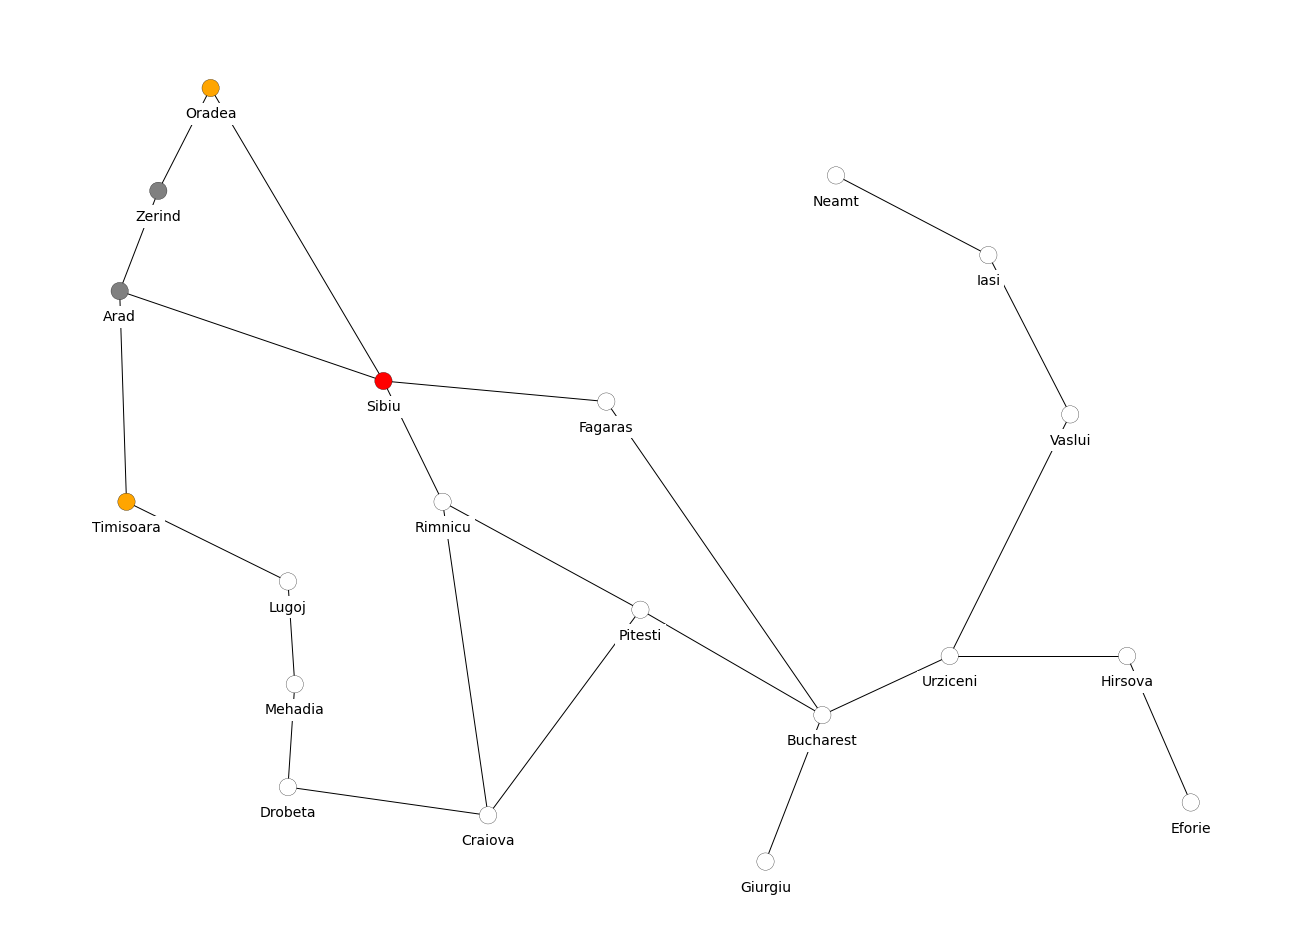

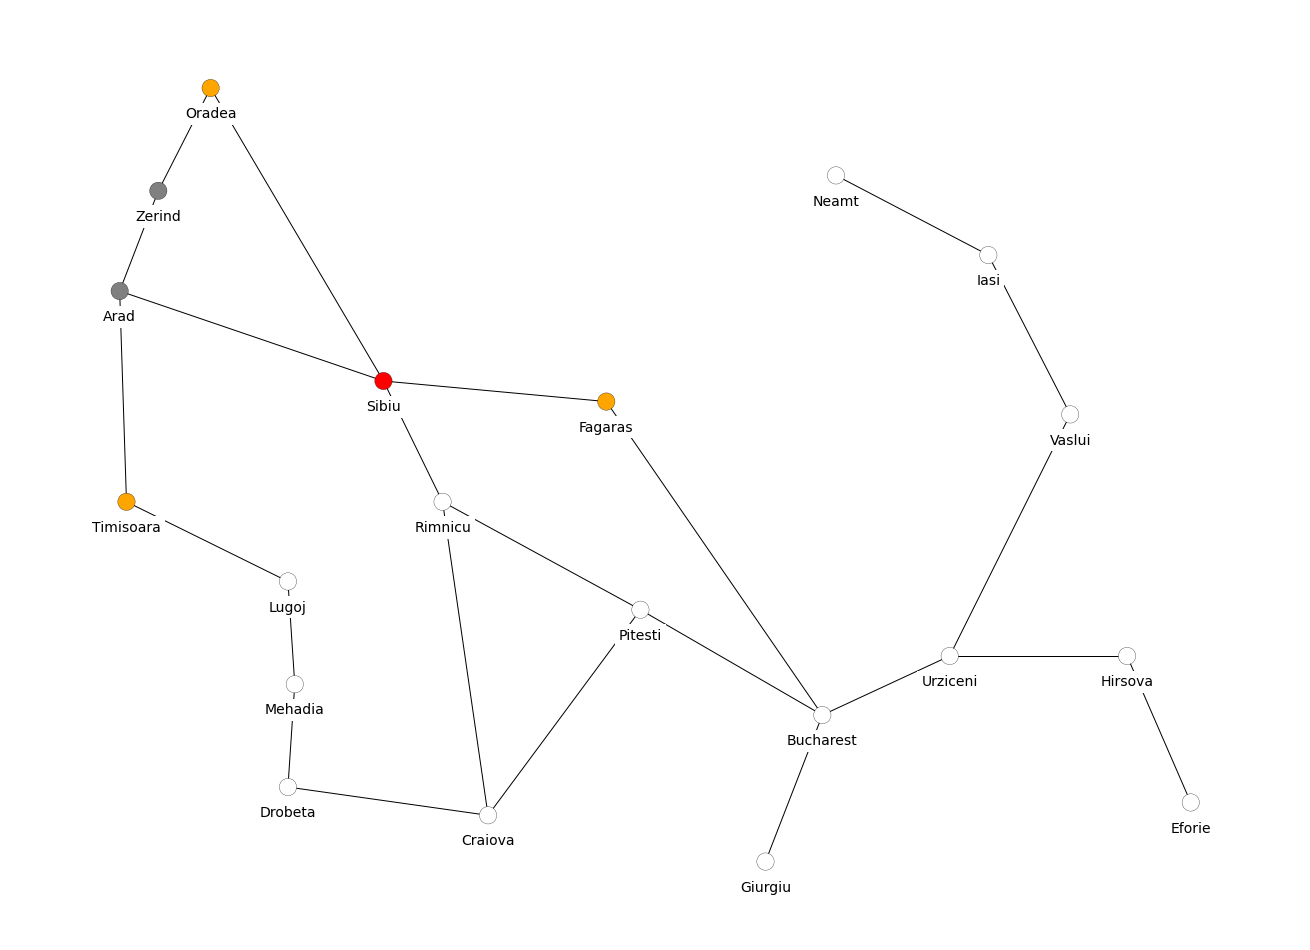

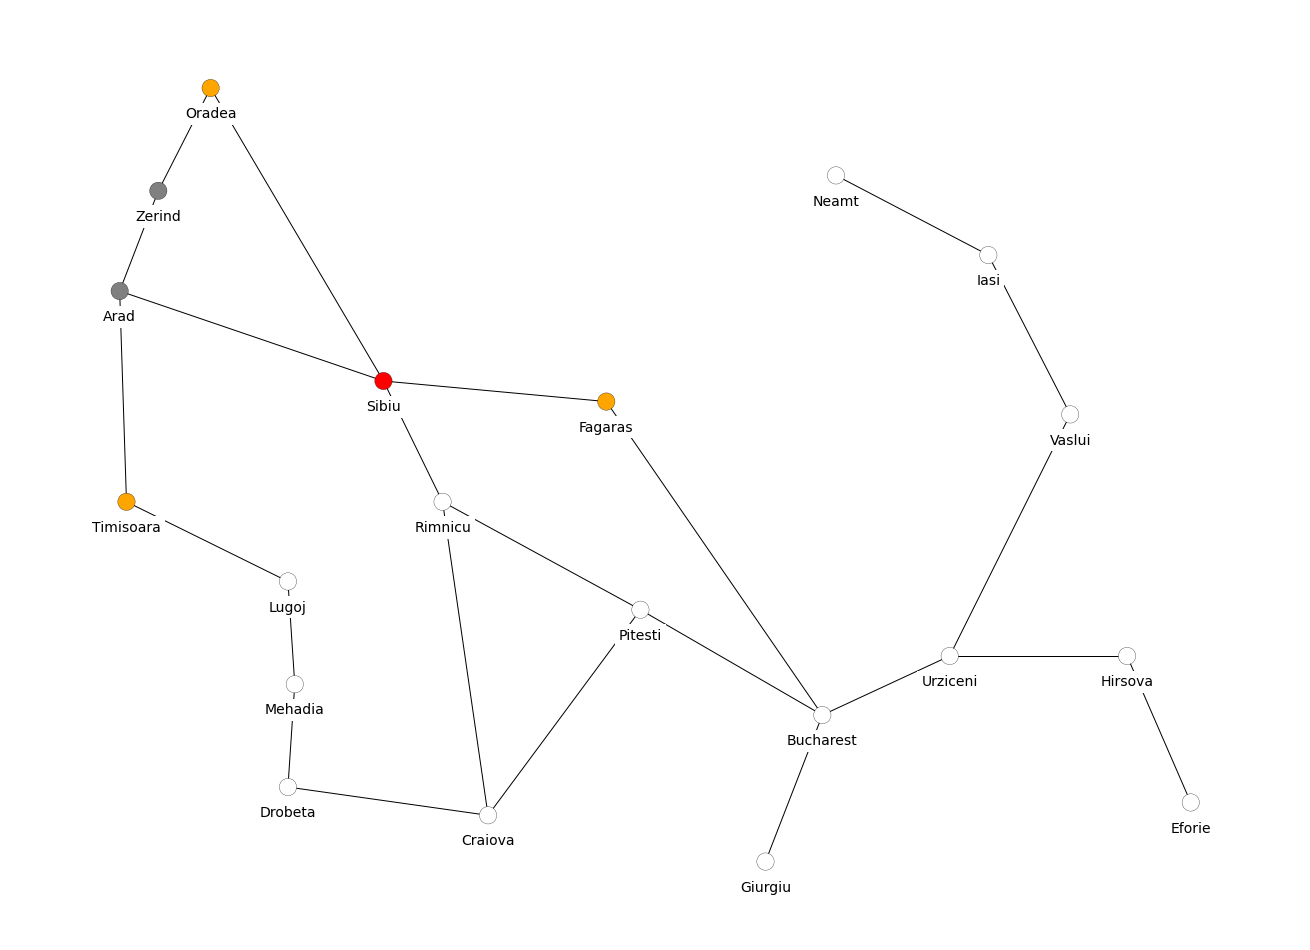

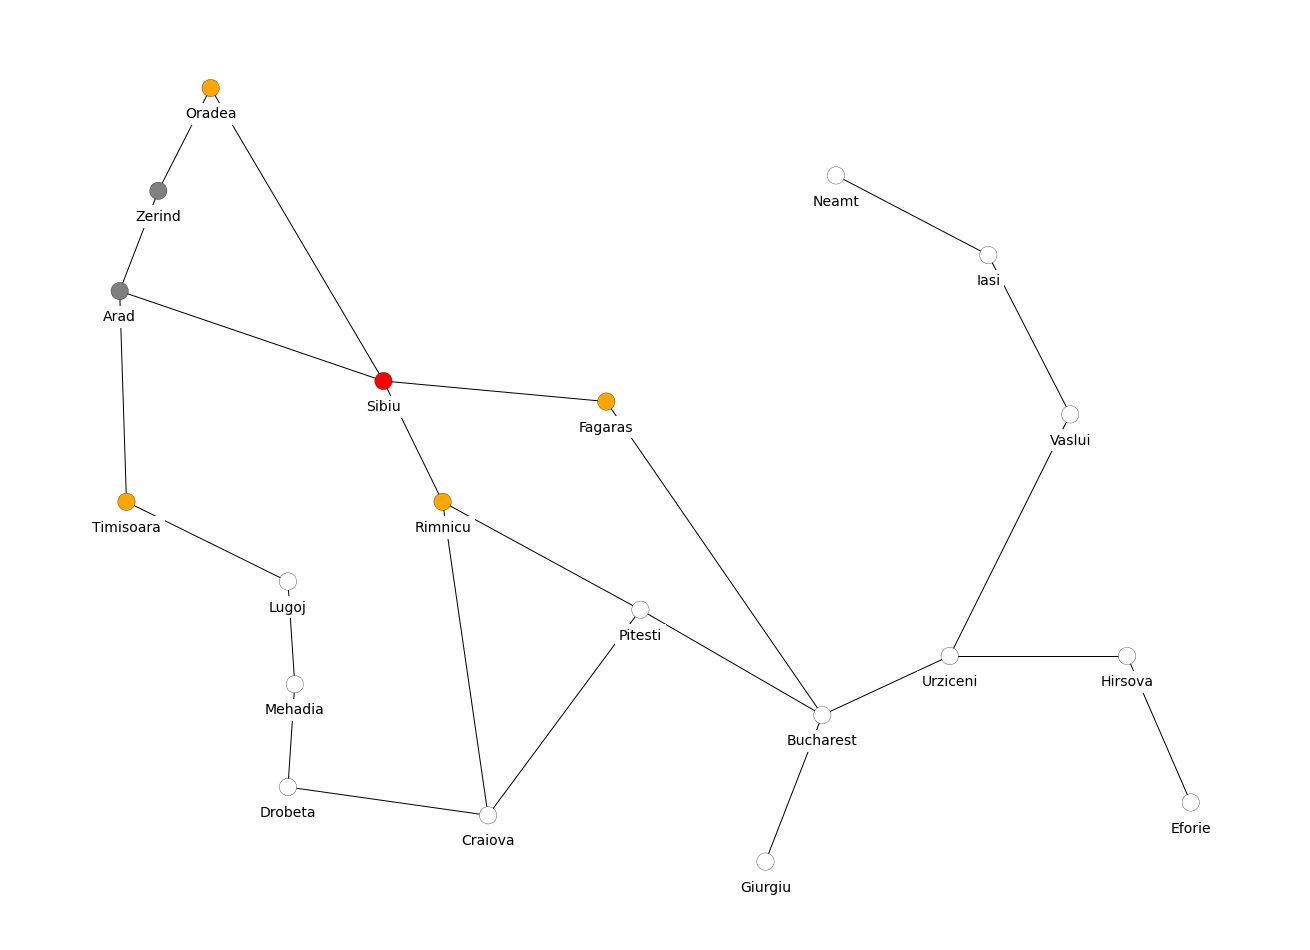

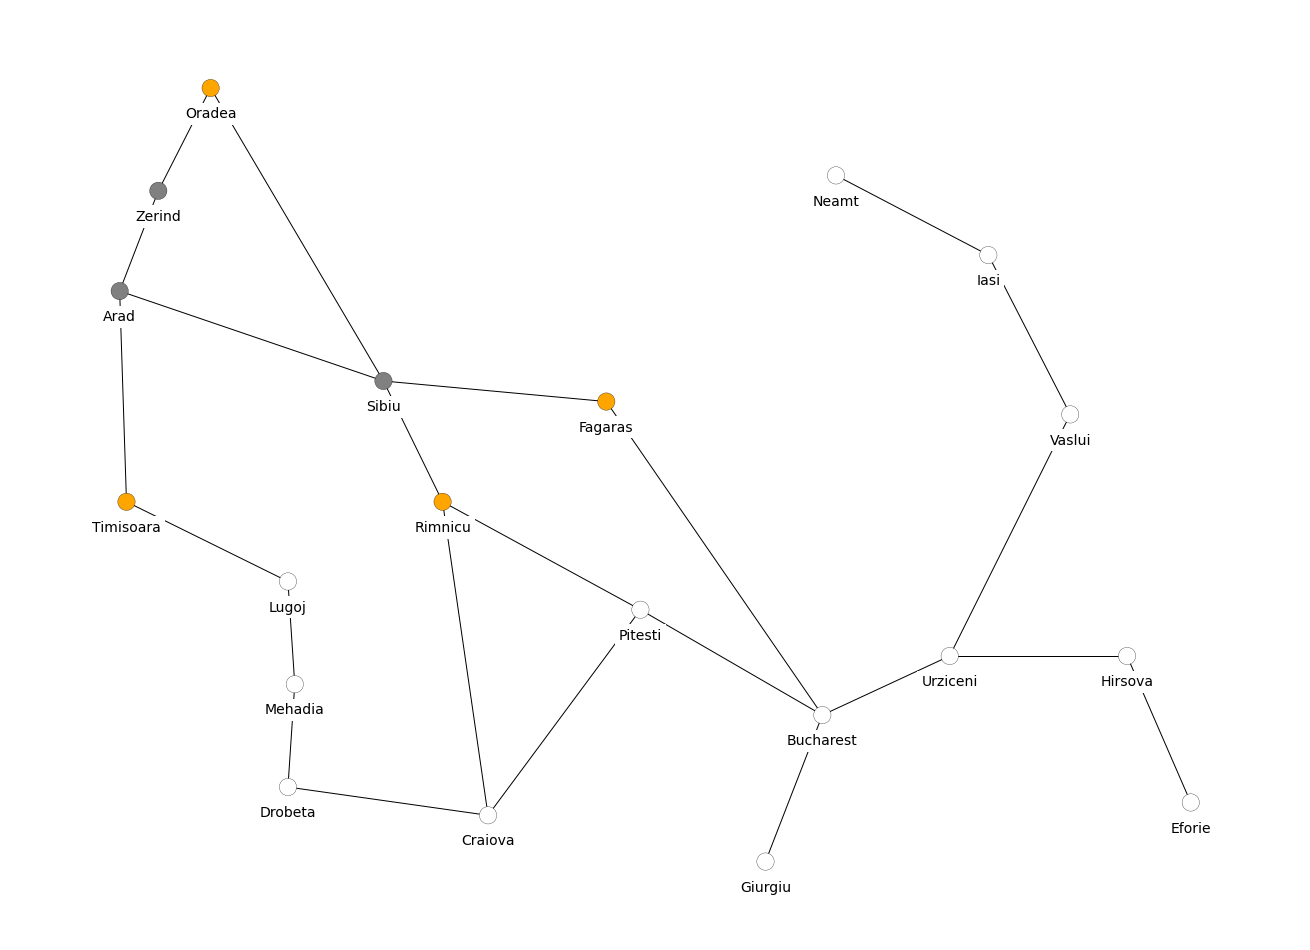

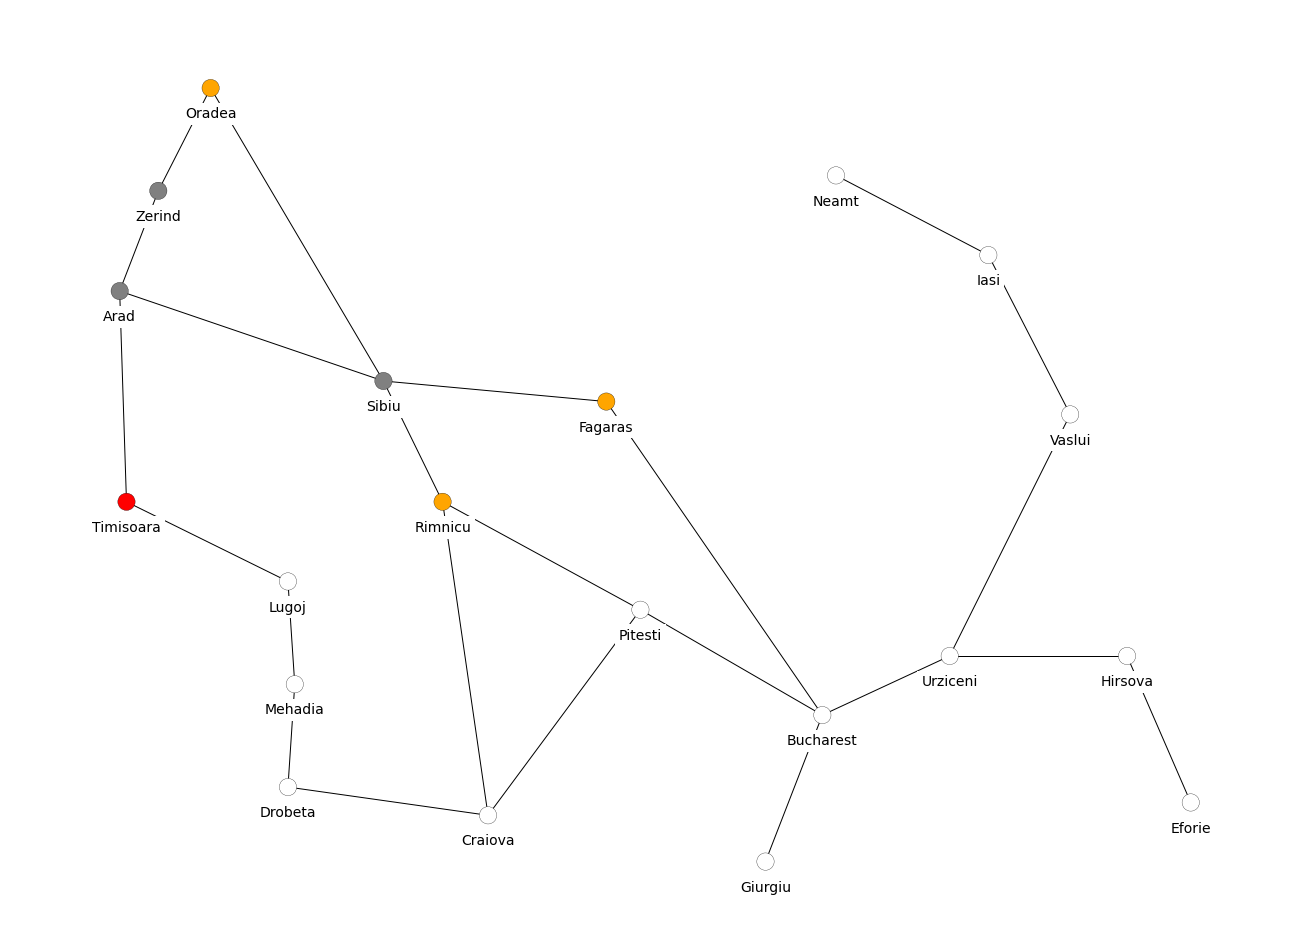

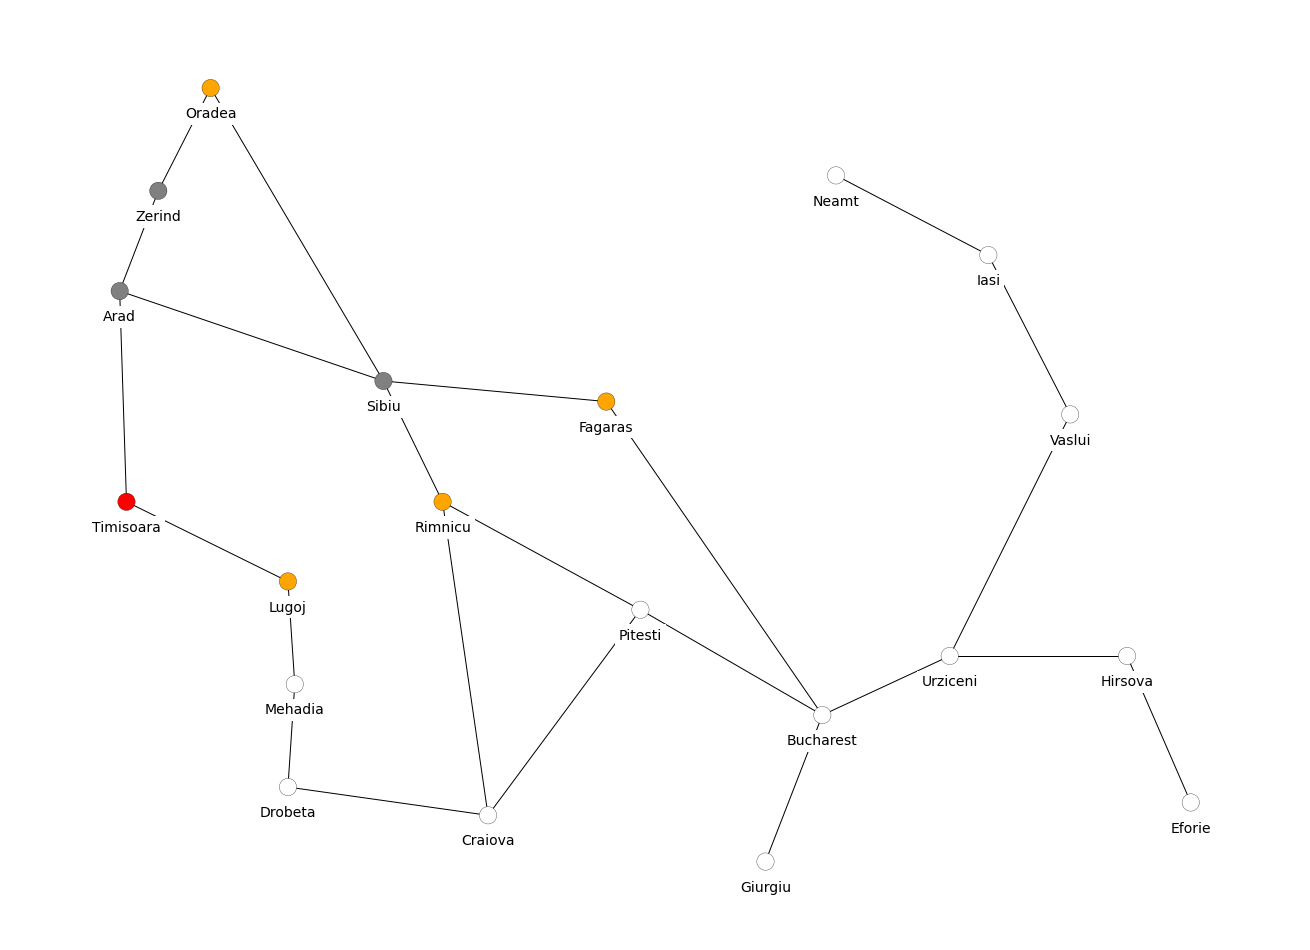

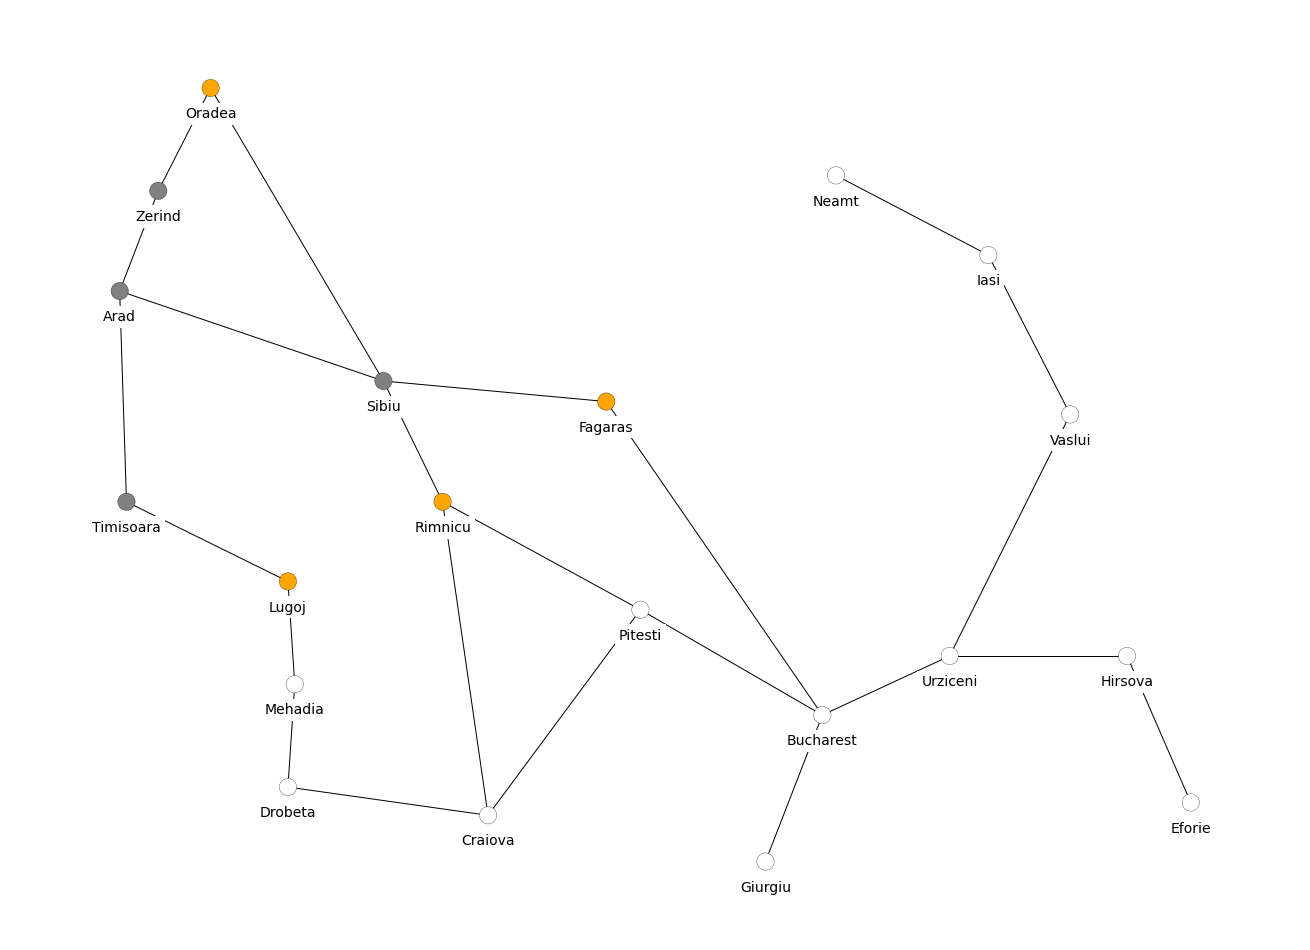

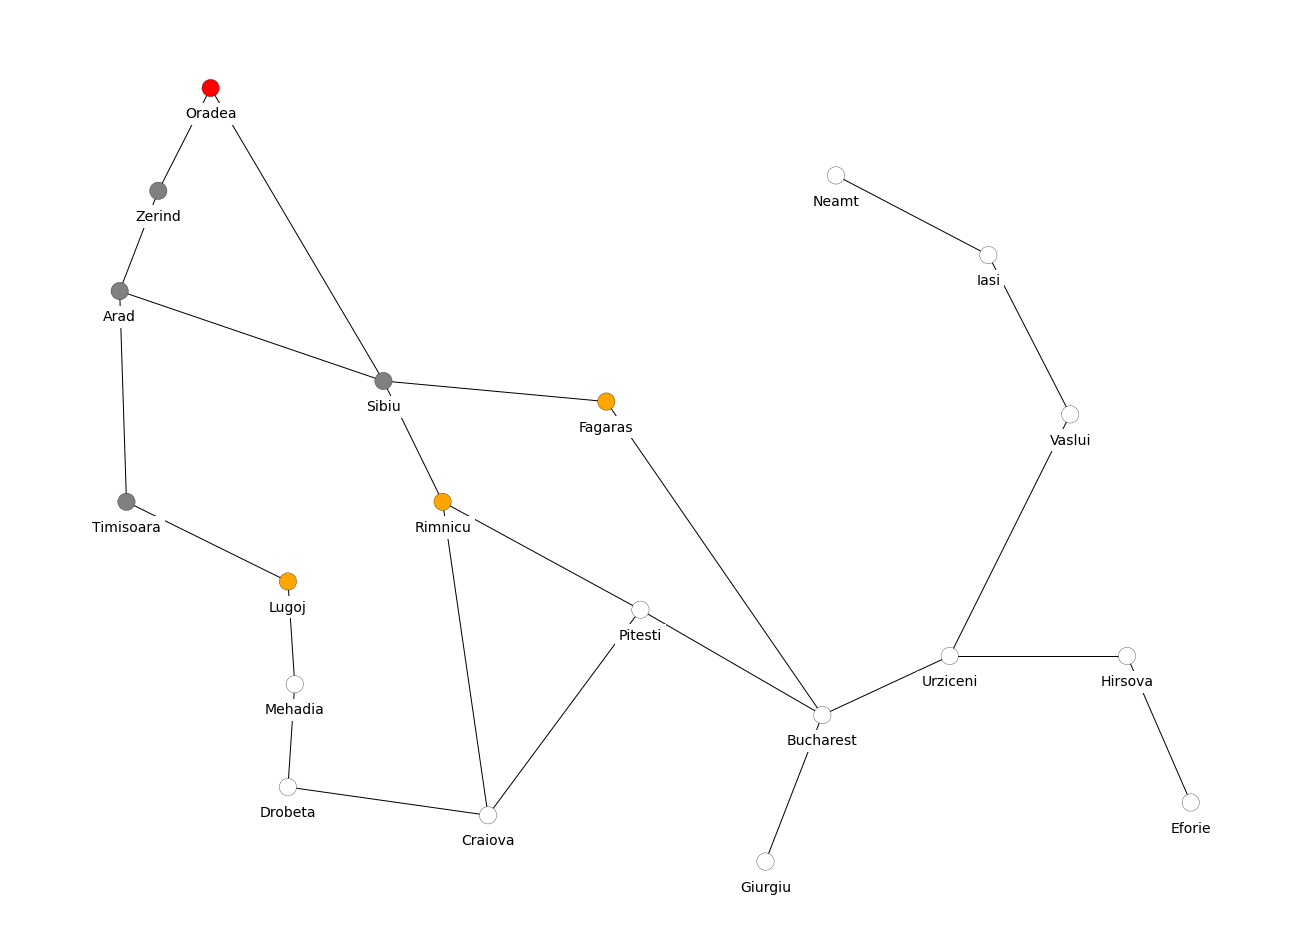

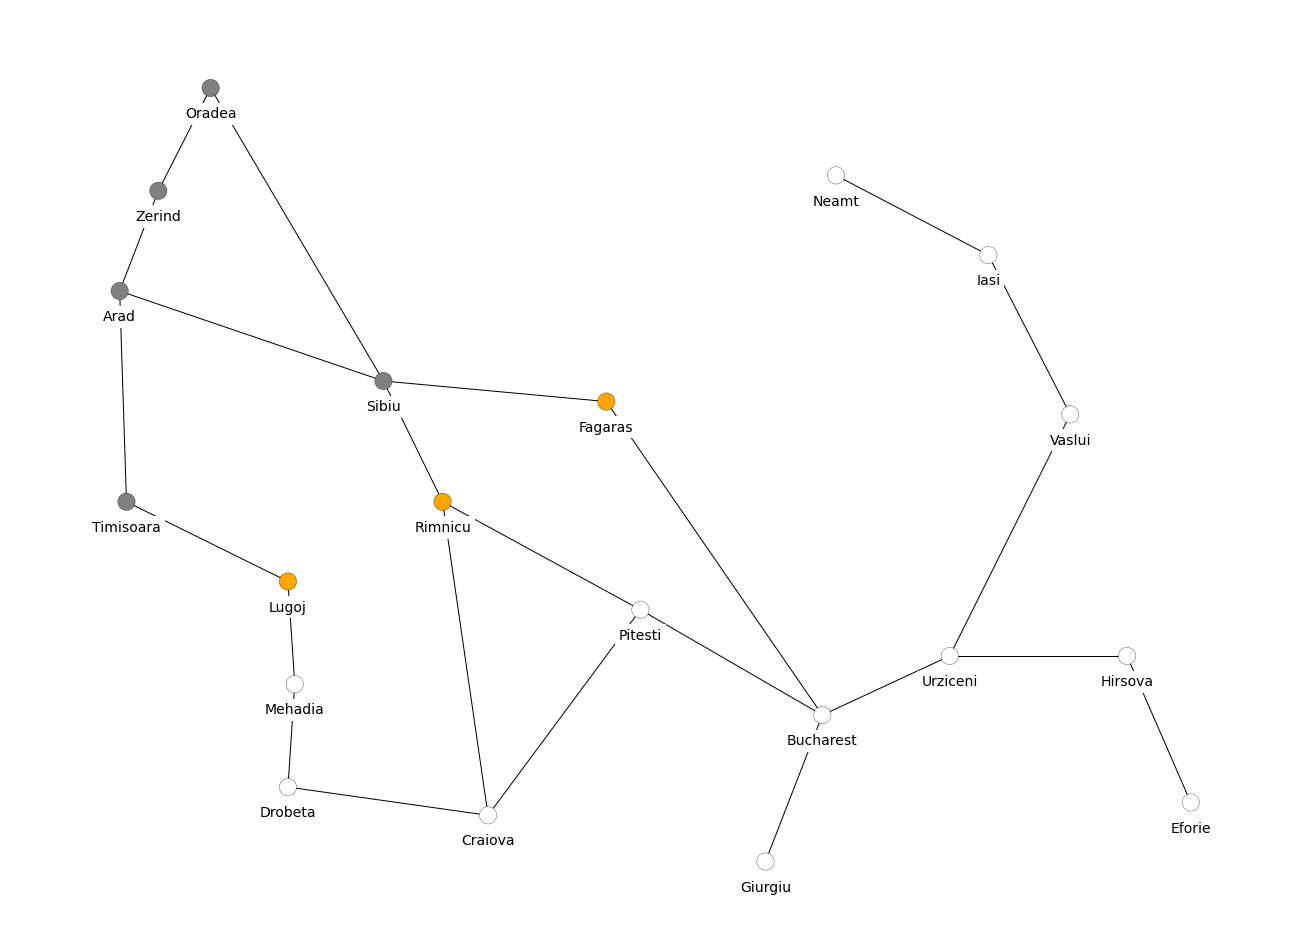

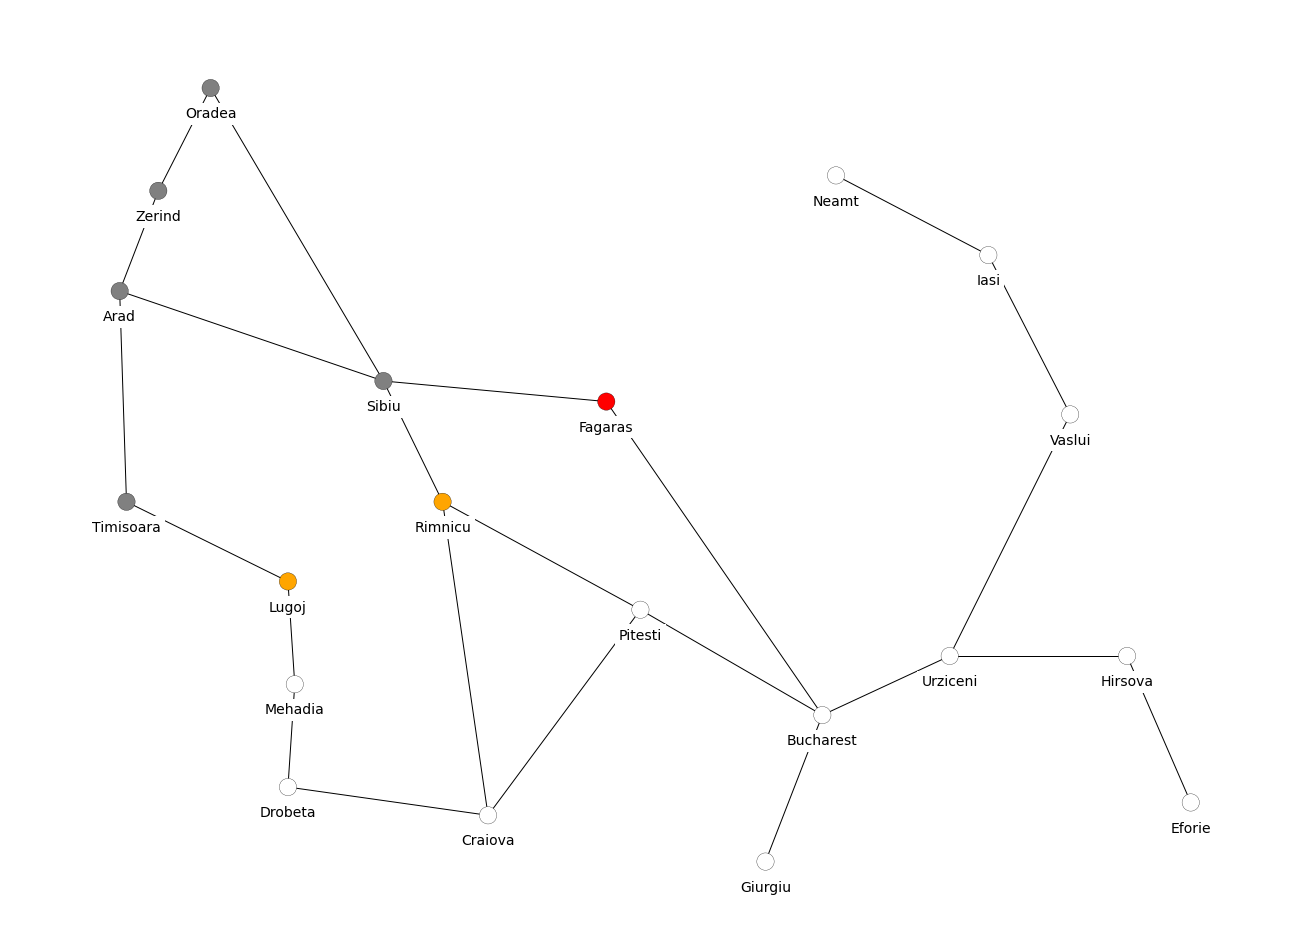

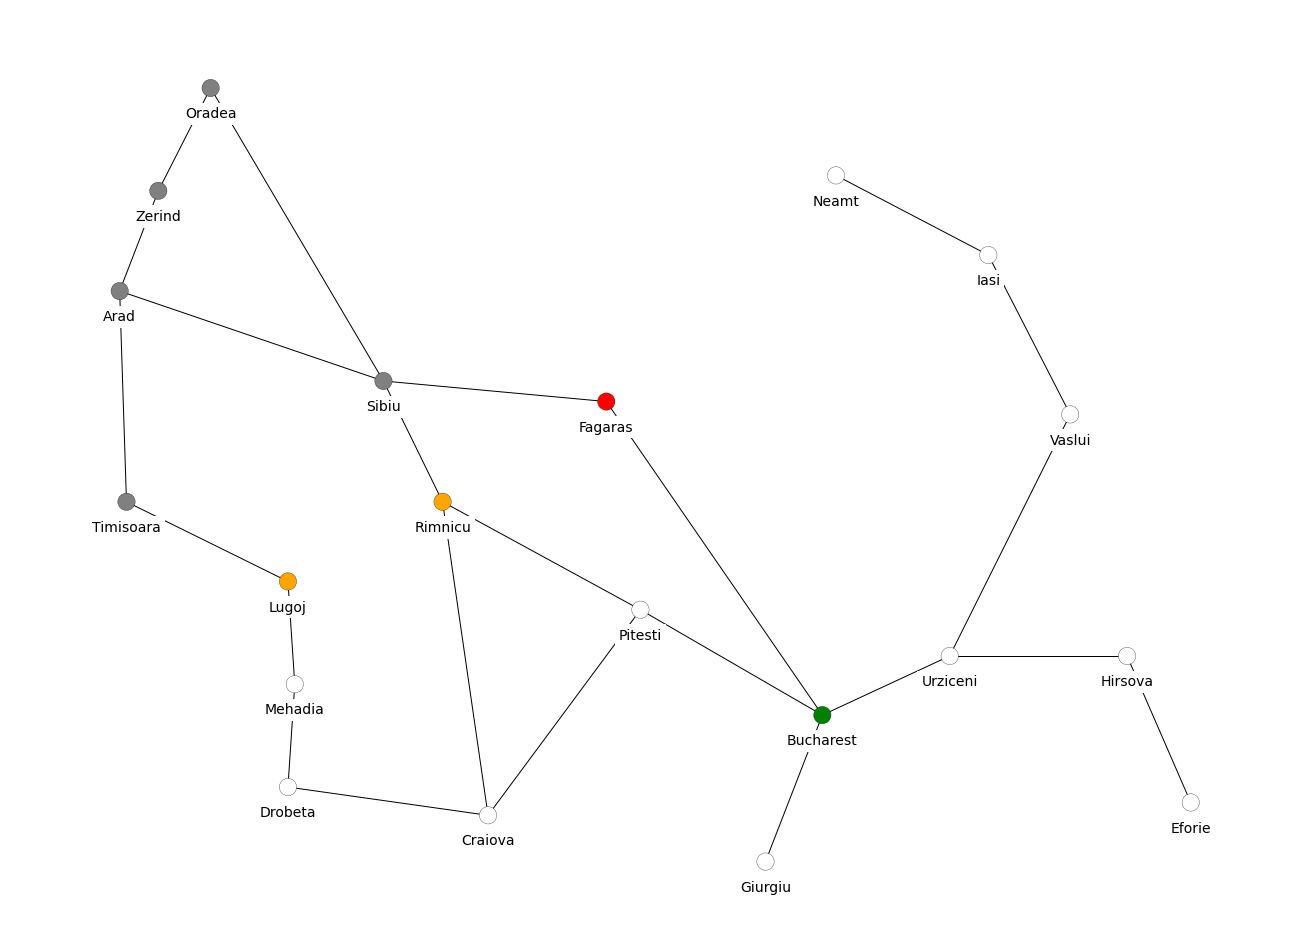

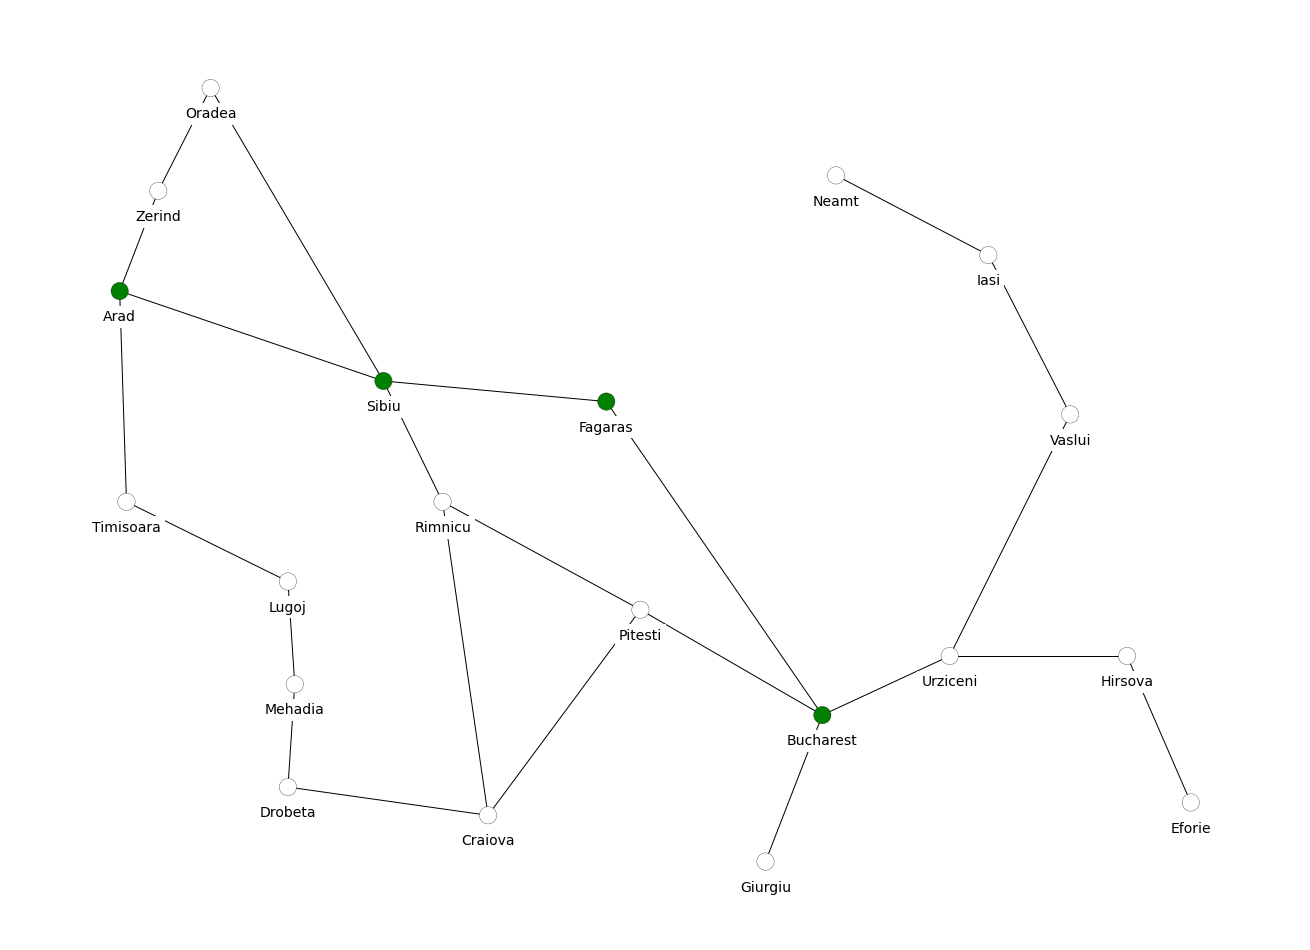

In [105]:
node_colors = {node: 'white' for node in a.locations.keys()}
node_positions = a.locations
node_label_pos = {k: [v[0], v[1] - 10] for k, v in a.locations.items()}

data = dict(
    graph_dict = a.graph_dict,
    node_col = node_colors,
    node_pos = node_positions,
    node_label_pos = node_label_pos
)


for i, color_data in enumerate(color_history):
    data = dict(
        graph_dict = a.graph_dict,
        node_col = color_data,
        node_pos = node_positions,
        node_label_pos = node_label_pos
    )
    save_map(data, i)

    
    

final_colors = {node: 'white' for node in a.locations.keys()}
final_colors[romania_problem.initial] = 'green'
for node in path[-1].solution():
    final_colors[node] = "green"
    
save_map(
    dict(
        graph_dict = a.graph_dict,
        node_col = final_colors,
        node_pos = node_positions,
        node_label_pos = node_label_pos
    ),
    len(color_history)
)